In [25]:
import subprocess
import sys
import re
import glob
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
sys.path.append("/Users/ugandharnapa/Documents/JHU/Courses/NLP/NLP-JHU/hw-lm/code")

lambda_cross_entropy = []

# for lamda in [5, 0.5, 0.05, 0.005, 0.0005]:
for lamda in [0.005]:
    gen_train_cmd = [
        "./train_lm.py",
        "vocab-genspam.txt",
        "add_lambda",
        "--lambda", f"{lamda}", 
        "../data/gen_spam/train/gen", 
        "--output", f"gen~lambda={lamda}.model"
    ]

    spam_train_cmd = [
        "./train_lm.py",
        "vocab-genspam.txt",
        "add_lambda",
        "--lambda", f"{lamda}", 
        "../data/gen_spam/train/spam", 
        "--output", f"spam~lambda={lamda}.model"
    ]
    
    gen_output_model = subprocess.run(gen_train_cmd, capture_output=True, text=True)
    spam_output_model = subprocess.run(spam_train_cmd, capture_output=True, text=True)
    
    gen_dev_files = glob.glob("../data/gen_spam/dev/gen/*.txt")
    gen_fileprob_cmd = ["./fileprob.py", f"gen~lambda={lamda}.model"] + gen_dev_files
    spam_dev_files = glob.glob("../data/gen_spam/dev/spam/*.txt")
    spam_fileprob_cmd = ["./fileprob.py", f"spam~lambda={lamda}.model"] + spam_dev_files
    
    gen_output = subprocess.run(gen_fileprob_cmd, capture_output=True, text=True).stdout
    spam_output = subprocess.run(spam_fileprob_cmd, capture_output=True, text=True).stdout

    gen_vocab_counts = int(gen_output.strip().split("\n")[-2].strip().split(":")[-1].strip())
    spam_vocab_counts = int(spam_output.strip().split("\n")[-2].strip().split(":")[-1].strip())
    
    gen_overall_cross_entropy_str = gen_output.strip().split("\n")[-1]
    spam_overall_cross_entropy_str = spam_output.strip().split("\n")[-1]
    
    gen_cross_entropy_str = gen_output.strip().split("\n")[-3]
    spam_cross_entropy_str = spam_output.strip().split("\n")[-3]
    
    gen_cross_entropy = float(re.search(r"(\d+\.\d+)", gen_cross_entropy_str.split(":")[-1].strip()).group(1))
    spam_cross_entropy = float(re.search(r"(\d+\.\d+)", spam_cross_entropy_str.split(":")[-1].strip()).group(1))
        
    gen_overall_cross_entropy = float(re.search(r"(\d+\.\d+)", gen_overall_cross_entropy_str.split(":")[-1].strip()).group(1))
    spam_overall_cross_entropy = float(re.search(r"(\d+\.\d+)", spam_overall_cross_entropy_str.split(":")[-1].strip()).group(1))
    
    overall_cross_entropy = (gen_cross_entropy + spam_cross_entropy) / (gen_vocab_counts + spam_vocab_counts)
    
    print(lamda, gen_cross_entropy, spam_cross_entropy, overall_cross_entropy)

    lambda_cross_entropy.append({
        "lambda": lamda,
        "gen_cross_entropy": gen_cross_entropy,
        "spam_cross_entropy": spam_cross_entropy,
        "gen_overall_cross_entropy": gen_overall_cross_entropy,
        "spam_overall_cross_entropy": spam_overall_cross_entropy,
        "gen_vocab_counts": gen_vocab_counts,
        "spam_vocab_counts": spam_vocab_counts,
        "overall_cross_entropy": overall_cross_entropy
        
    })

IndexError: list index out of range

In [47]:
gen_file_cross_entropy = []
for op_line in gen_output.strip().split("\n")[:-3]:
    cross_entropy, file_path  = op_line.split("\t")
    
    gen_file_cross_entropy.append({
        "cross_entropy": float(cross_entropy),
        "vocab_counts": int(file_path.split("/")[-1].split(".")[1])
    })

In [48]:
spam_file_cross_entropy = []
for op_line in spam_output.strip().split("\n")[:-3]:
    cross_entropy, file_path  = op_line.split("\t")
    
    spam_file_cross_entropy.append({
        "cross_entropy": float(cross_entropy),
        "vocab_counts": int(file_path.split("/")[-1].split(".")[1])
    })

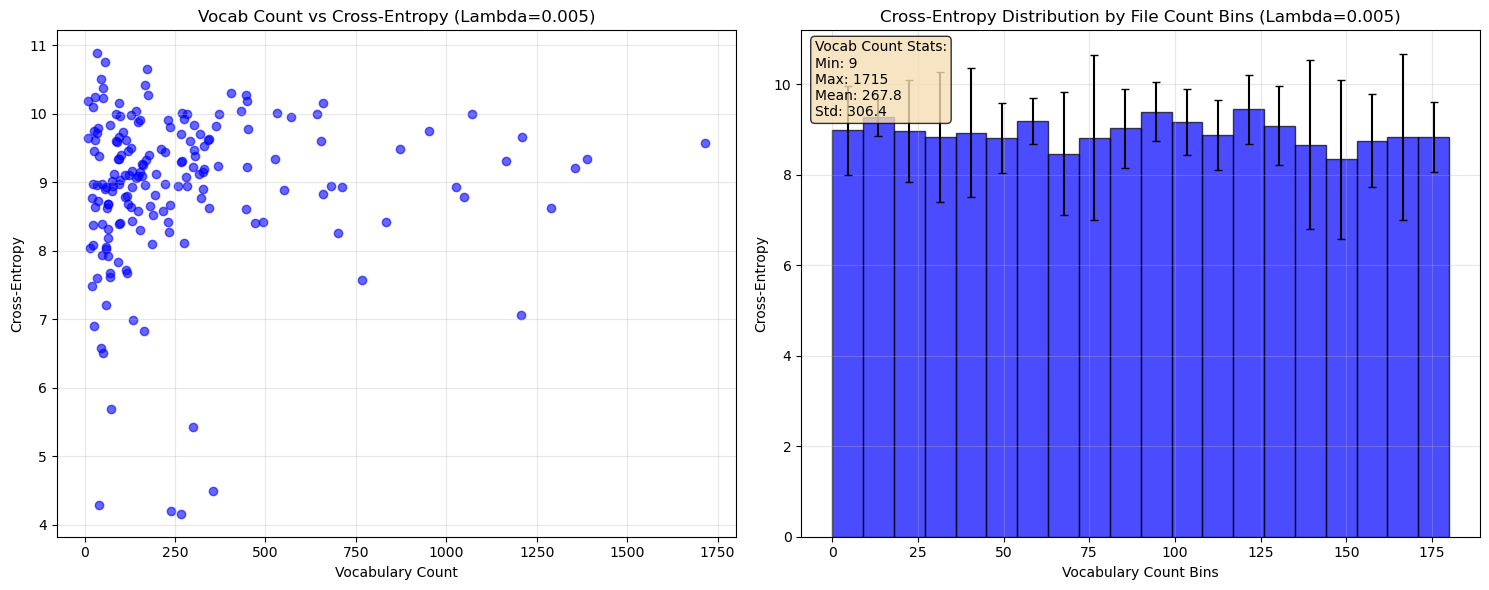

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

gen_df = pd.DataFrame(gen_file_cross_entropy)
ax1.scatter(gen_df['vocab_counts'], gen_df['cross_entropy'], alpha=0.6, color='blue')
ax1.set_xlabel('Vocabulary Count')
ax1.set_ylabel('Cross-Entropy')
ax1.set_title('Vocab Count vs Cross-Entropy (Lambda=0.005)')
ax1.grid(True, alpha=0.3)

# Create bins based on file indices (file counts)
num_bins = 20
file_indices = range(len(gen_df))
bin_edges = np.linspace(0, len(gen_df), num_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate mean cross-entropy for each bin
bin_means = []
bin_stds = []
for i in range(num_bins):
    start_idx = int(bin_edges[i])
    end_idx = int(bin_edges[i + 1])
    if start_idx < len(gen_df):
        bin_data = gen_df.iloc[start_idx:end_idx]['cross_entropy']
        bin_means.append(bin_data.mean())
        bin_stds.append(bin_data.std())

# Create histogram with error bars
ax2.bar(bin_centers, bin_means, width=bin_edges[1] - bin_edges[0], 
        alpha=0.7, color='blue', edgecolor='black', yerr=bin_stds, capsize=3)
ax2.set_xlabel('Vocabulary Count Bins')
ax2.set_ylabel('Cross-Entropy')
ax2.set_title('Cross-Entropy Distribution by File Count Bins (Lambda=0.005)')
ax2.grid(True, alpha=0.3)

vocab_stats = f"Vocab Count Stats:\nMin: {gen_df['vocab_counts'].min()}\nMax: {gen_df['vocab_counts'].max()}\nMean: {gen_df['vocab_counts'].mean():.1f}\nStd: {gen_df['vocab_counts'].std():.1f}"
ax2.text(0.02, 0.98, vocab_stats, transform=ax2.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()


In [45]:
# Additional analysis: Cross-entropy vs vocab count correlation
print("Correlation between vocab count and cross-entropy:")
correlation = gen_df['vocab_counts'].corr(gen_df['cross_entropy'])
print(f"Correlation coefficient: {correlation:.4f}")

print("\nVocab count statistics:")
print(gen_df['vocab_counts'].describe())

print("\nCross-entropy statistics:")
print(gen_df['cross_entropy'].describe())


Correlation between vocab count and cross-entropy:
Correlation coefficient: -0.0827

Vocab count statistics:
count     180.000000
mean      267.766667
std       306.440150
min         9.000000
25%        70.750000
50%       156.500000
75%       323.250000
max      1715.000000
Name: vocab_counts, dtype: float64

Cross-entropy statistics:
count    180.000000
mean      -6.195643
std        0.795990
min       -7.543510
25%       -6.697298
50%       -6.314885
75%       -5.950837
max       -2.885070
Name: cross_entropy, dtype: float64


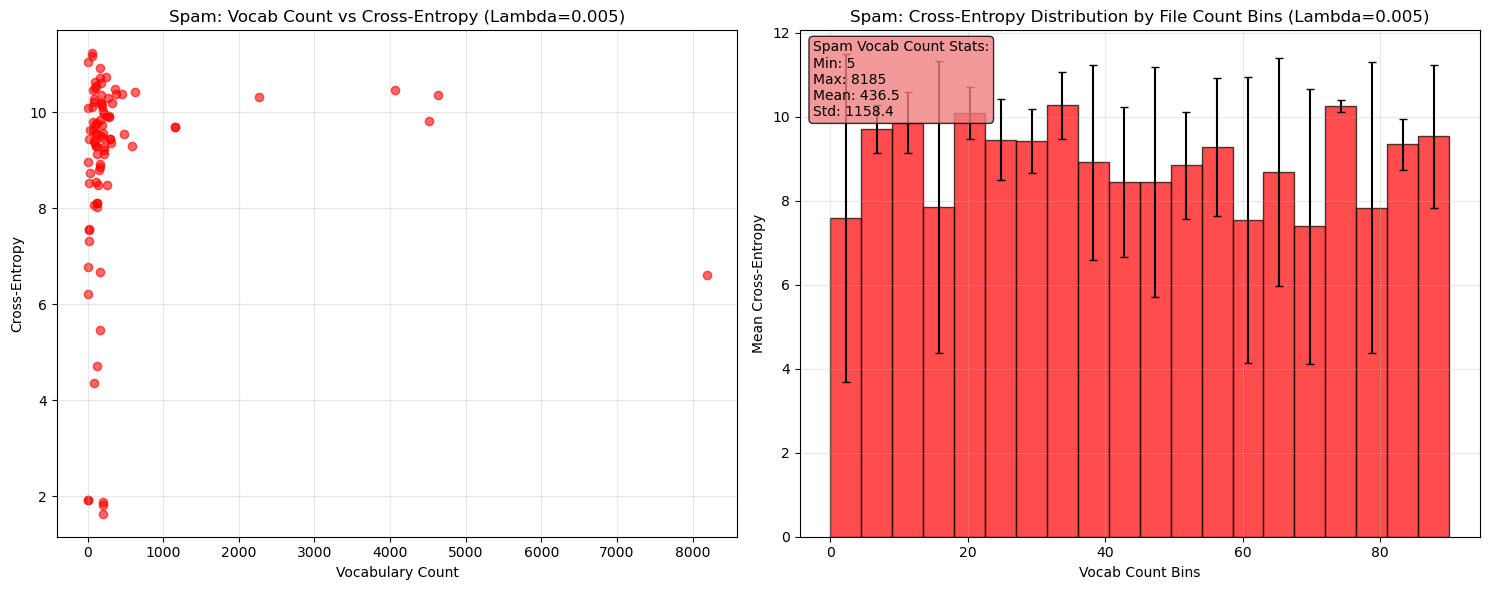

In [53]:
# Create side-by-side plots for spam data (lambda=0.005)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Scatter plot of vocab count against cross-entropy for spam
spam_df = pd.DataFrame(spam_file_cross_entropy)
ax1.scatter(spam_df['vocab_counts'], spam_df['cross_entropy'], alpha=0.6, color='red')
ax1.set_xlabel('Vocabulary Count')
ax1.set_ylabel('Cross-Entropy')
ax1.set_title('Spam: Vocab Count vs Cross-Entropy (Lambda=0.005)')
ax1.grid(True, alpha=0.3)

# Plot 2: Histogram with bins of file counts and cross-entropy distribution for spam
# Create bins based on file indices (file counts)
num_bins = 20
file_indices = range(len(spam_df))
bin_edges = np.linspace(0, len(spam_df), num_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate mean cross-entropy for each bin
bin_means = []
bin_stds = []
for i in range(num_bins):
    start_idx = int(bin_edges[i])
    end_idx = int(bin_edges[i + 1])
    if start_idx < len(spam_df):
        bin_data = spam_df.iloc[start_idx:end_idx]['cross_entropy']
        bin_means.append(bin_data.mean())
        bin_stds.append(bin_data.std())

# Create histogram with error bars
ax2.bar(bin_centers, bin_means, width=bin_edges[1] - bin_edges[0], 
        alpha=0.7, color='red', edgecolor='black', yerr=bin_stds, capsize=3)
ax2.set_xlabel('Vocab Count Bins')
ax2.set_ylabel('Mean Cross-Entropy')
ax2.set_title('Spam: Cross-Entropy Distribution by File Count Bins (Lambda=0.005)')
ax2.grid(True, alpha=0.3)

# Add text annotation showing vocab count statistics for spam
spam_vocab_stats = f"Spam Vocab Count Stats:\nMin: {spam_df['vocab_counts'].min()}\nMax: {spam_df['vocab_counts'].max()}\nMean: {spam_df['vocab_counts'].mean():.1f}\nStd: {spam_df['vocab_counts'].std():.1f}"
ax2.text(0.02, 0.98, spam_vocab_stats, transform=ax2.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))

plt.tight_layout()
plt.show()


In [54]:
# Additional analysis for spam: Cross-entropy vs vocab count correlation
print("SPAM DATA ANALYSIS:")
print("Correlation between vocab count and cross-entropy:")
spam_correlation = spam_df['vocab_counts'].corr(spam_df['cross_entropy'])
print(f"Correlation coefficient: {spam_correlation:.4f}")

print("\nSpam vocab count statistics:")
print(spam_df['vocab_counts'].describe())

print("\nSpam cross-entropy statistics:")
print(spam_df['cross_entropy'].describe())

print("\n" + "="*50)
print("COMPARISON: Gen vs Spam")
print("="*50)
print(f"Gen correlation: {correlation:.4f}")
print(f"Spam correlation: {spam_correlation:.4f}")
print(f"Gen mean vocab count: {gen_df['vocab_counts'].mean():.1f}")
print(f"Spam mean vocab count: {spam_df['vocab_counts'].mean():.1f}")
print(f"Gen mean cross-entropy: {gen_df['cross_entropy'].mean():.1f}")
print(f"Spam mean cross-entropy: {spam_df['cross_entropy'].mean():.1f}")


SPAM DATA ANALYSIS:
Correlation between vocab count and cross-entropy:
Correlation coefficient: 0.0327

Spam vocab count statistics:
count      90.000000
mean      436.488889
std      1158.415920
min         5.000000
25%        87.500000
50%       160.500000
75%       234.250000
max      8185.000000
Name: vocab_counts, dtype: float64

Spam cross-entropy statistics:
count    90.000000
mean      8.909474
std       2.172917
min       1.639890
25%       8.599440
50%       9.554480
75%      10.198900
max      11.228000
Name: cross_entropy, dtype: float64

COMPARISON: Gen vs Spam
Gen correlation: -0.0827
Spam correlation: 0.0327
Gen mean vocab count: 267.8
Spam mean vocab count: 436.5
Gen mean cross-entropy: 8.9
Spam mean cross-entropy: 8.9


3h

In [ ]:
# Learning curve analysis: Error rate vs training data size
import subprocess
import glob

# Define training data sizes and corresponding files
training_sizes = {
    '1x': {'gen': 'gen', 'spam': 'spam'},
    '2x': {'gen': 'gen-times2', 'spam': 'spam-times2'},
    '4x': {'gen': 'gen-times4', 'spam': 'spam-times4'},
    '8x': {'gen': 'gen-times8', 'spam': 'spam-times8'}
}

# Use lambda=0.005 (best from previous analysis)
lambda_val = 0.005
learning_curve_data = []

print("Training models with different data sizes...")
print("="*60)

for size_name, files in training_sizes.items():
    print(f"\nTraining with {size_name} data...")
    
    # Train Gen model
    gen_train_cmd = [
        "./train_lm.py",
        "vocab-genspam.txt",
        "add_lambda",
        "--lambda", f"{lambda_val}", 
        f"../data/gen_spam/train/{files['gen']}", 
        "--output", f"gen_{size_name}_lambda_{lambda_val}.model"
    ]
    
    # Train Spam model
    spam_train_cmd = [
        "./train_lm.py",
        "vocab-genspam.txt",
        "add_lambda",
        "--lambda", f"{lambda_val}", 
        f"../data/gen_spam/train/{files['spam']}", 
        "--output", f"spam_{size_name}_lambda_{lambda_val}.model"
    ]
    
    # Train models
    gen_output = subprocess.run(gen_train_cmd, capture_output=True, text=True)
    spam_output = subprocess.run(spam_train_cmd, capture_output=True, text=True)
    
    print(f"Gen model trained: {gen_output.returncode == 0}")
    print(f"Spam model trained: {spam_output.returncode == 0}")
    
    # Test on dev data
    gen_dev_files = glob.glob("../data/gen_spam/dev/gen/*.txt")
    spam_dev_files = glob.glob("../data/gen_spam/dev/spam/*.txt")
    
    # Get predictions for Gen dev files
    gen_gen_cmd = ["./fileprob.py", f"gen_{size_name}_lambda_{lambda_val}.model"] + gen_dev_files
    gen_spam_cmd = ["./fileprob.py", f"spam_{size_name}_lambda_{lambda_val}.model"] + gen_dev_files
    
    gen_gen_output = subprocess.run(gen_gen_cmd, capture_output=True, text=True).stdout
    gen_spam_output = subprocess.run(gen_spam_cmd, capture_output=True, text=True).stdout
    
    # Get predictions for Spam dev files
    spam_gen_cmd = ["./fileprob.py", f"gen_{size_name}_lambda_{lambda_val}.model"] + spam_dev_files
    spam_spam_cmd = ["./fileprob.py", f"spam_{size_name}_lambda_{lambda_val}.model"] + spam_dev_files
    
    spam_gen_output = subprocess.run(spam_gen_cmd, capture_output=True, text=True).stdout
    spam_spam_output = subprocess.run(spam_spam_cmd, capture_output=True, text=True).stdout
    
    # Parse cross-entropy values
    gen_gen_scores = []
    gen_spam_scores = []
    spam_gen_scores = []
    spam_spam_scores = []
    
    for line in gen_gen_output.strip().split('\n')[:-3]:
        if line.strip():
            score = float(line.split('\t')[0])
            gen_gen_scores.append(score)
    
    for line in gen_spam_output.strip().split('\n')[:-3]:
        if line.strip():
            score = float(line.split('\t')[0])
            gen_spam_scores.append(score)
    
    for line in spam_gen_output.strip().split('\n')[:-3]:
        if line.strip():
            score = float(line.split('\t')[0])
            spam_gen_scores.append(score)
    
    for line in spam_spam_output.strip().split('\n')[:-3]:
        if line.strip():
            score = float(line.split('\t')[0])
            spam_spam_scores.append(score)
    
    # Calculate error rate (lower cross-entropy = better model for that class)
    gen_correct = sum(1 for i in range(len(gen_gen_scores)) if gen_gen_scores[i] < gen_spam_scores[i])
    spam_correct = sum(1 for i in range(len(spam_spam_scores)) if spam_spam_scores[i] < spam_gen_scores[i])
    
    total_files = len(gen_gen_scores) + len(spam_spam_scores)
    total_correct = gen_correct + spam_correct
    error_rate = 1 - (total_correct / total_files)
    
    print(f"Gen files: {gen_correct}/{len(gen_gen_scores)} correct")
    print(f"Spam files: {spam_correct}/{len(spam_spam_scores)} correct")
    print(f"Overall error rate: {error_rate:.4f}")
    
    learning_curve_data.append({
        'size': size_name,
        'size_numeric': int(size_name.replace('x', '')),
        'error_rate': error_rate,
        'gen_correct': gen_correct,
        'spam_correct': spam_correct,
        'total_files': total_files
    })

print("\n" + "="*60)
print("LEARNING CURVE RESULTS:")
print("="*60)
for data in learning_curve_data:
    print(f"{data['size']}: Error rate = {data['error_rate']:.4f}")


Training models with different data sizes...

Training with 1x data...
Gen model trained: True
Spam model trained: True
Gen files: 177/180 correct
Spam files: 62/90 correct
Overall error rate: 0.1148

Training with 2x data...
Gen model trained: True
Spam model trained: True
Gen files: 175/180 correct
Spam files: 74/90 correct
Overall error rate: 0.0778

Training with 4x data...
Gen model trained: True
Spam model trained: True
Gen files: 173/180 correct
Spam files: 80/90 correct
Overall error rate: 0.0630

Training with 8x data...
Gen model trained: True
Spam model trained: True
Gen files: 178/180 correct
Spam files: 76/90 correct
Overall error rate: 0.0593

LEARNING CURVE RESULTS:
1x: Error rate = 0.1148
2x: Error rate = 0.0778
4x: Error rate = 0.0630
8x: Error rate = 0.0593


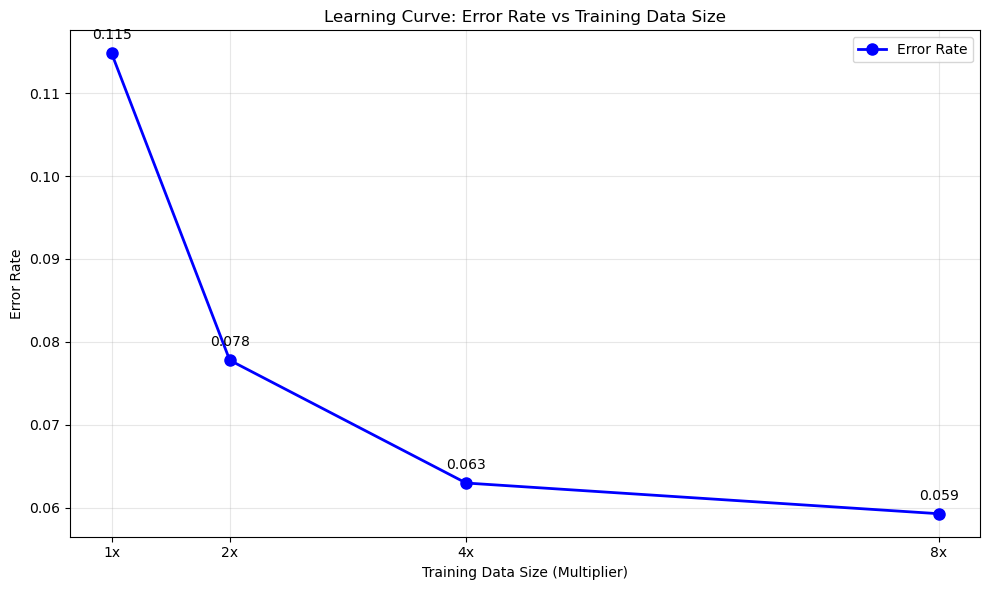


DETAILED LEARNING CURVE ANALYSIS:
Training Size: 1x
  Error Rate: 0.1148
  Gen Correct: 177
  Spam Correct: 62
  Total Files: 270

Training Size: 2x
  Error Rate: 0.0778
  Gen Correct: 175
  Spam Correct: 74
  Total Files: 270

Training Size: 4x
  Error Rate: 0.0630
  Gen Correct: 173
  Spam Correct: 80
  Total Files: 270

Training Size: 8x
  Error Rate: 0.0593
  Gen Correct: 178
  Spam Correct: 76
  Total Files: 270

LEARNING CURVE ANALYSIS:
Initial error rate (1x): 0.1148
Final error rate (8x): 0.0593
Improvement: 0.0556
Relative improvement: 48.4%
Error rate is decreasing: True

Expected behavior: Error rate should generally decrease as training data increases.
However, error rate may not approach 0 due to:
- Model capacity limitations
- Noise in the data
- Inherent ambiguity in some examples
- Model bias and variance trade-offs


In [57]:
# Create learning curve plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Convert data to DataFrame for easier plotting
lc_df = pd.DataFrame(learning_curve_data)

# Plot learning curve
ax.plot(lc_df['size_numeric'], lc_df['error_rate'], 'bo-', linewidth=2, markersize=8, label='Error Rate')
ax.set_xlabel('Training Data Size (Multiplier)')
ax.set_ylabel('Error Rate')
ax.set_title('Learning Curve: Error Rate vs Training Data Size')
ax.grid(True, alpha=0.3)
ax.legend()

# Add data point labels
for i, row in lc_df.iterrows():
    ax.annotate(f'{row["error_rate"]:.3f}', 
                (row['size_numeric'], row['error_rate']), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center')

# Set x-axis to show training data sizes
ax.set_xticks(lc_df['size_numeric'])
ax.set_xticklabels([f'{size}x' for size in lc_df['size_numeric']])

plt.tight_layout()
plt.show()

# Print detailed results
print("\nDETAILED LEARNING CURVE ANALYSIS:")
print("="*50)
for i, data in enumerate(learning_curve_data):
    print(f"Training Size: {data['size']}")
    print(f"  Error Rate: {data['error_rate']:.4f}")
    print(f"  Gen Correct: {data['gen_correct']}")
    print(f"  Spam Correct: {data['spam_correct']}")
    print(f"  Total Files: {data['total_files']}")
    print()

# Analysis of learning curve
print("LEARNING CURVE ANALYSIS:")
print("="*30)
if len(learning_curve_data) > 1:
    initial_error = learning_curve_data[0]['error_rate']
    final_error = learning_curve_data[-1]['error_rate']
    improvement = initial_error - final_error
    print(f"Initial error rate (1x): {initial_error:.4f}")
    print(f"Final error rate (8x): {final_error:.4f}")
    print(f"Improvement: {improvement:.4f}")
    print(f"Relative improvement: {(improvement/initial_error)*100:.1f}%")
    
    # Check if error rate is decreasing
    error_rates = [d['error_rate'] for d in learning_curve_data]
    is_decreasing = all(error_rates[i] >= error_rates[i+1] for i in range(len(error_rates)-1))
    print(f"Error rate is decreasing: {is_decreasing}")
    
    print(f"\nExpected behavior: Error rate should generally decrease as training data increases.")
    print(f"However, error rate may not approach 0 due to:")
    print(f"- Model capacity limitations")
    print(f"- Noise in the data")
    print(f"- Inherent ambiguity in some examples")
    print(f"- Model bias and variance trade-offs")
